TODO
- add directions in markdown

In [1]:
#Options
tname="TESTING"
tstamp=0 #add time stamps to output for benchmarking
stepsize=0.05 #units of g, used for bin size in histogram.  0.05 for full shipment, larger for shorter.
spec=1.5 #units of g, flag any shocks higher than this level

In [2]:
import os
import re
import sys

from datetime import datetime 
import endaq.ide as ed
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd

print(f"Python Version: {sys.version}")

#Variable initialization where needed
out=[]

Python Version: 3.10.11 | packaged by Anaconda, Inc. | (main, Apr 20 2023, 18:56:50) [MSC v.1916 64 bit (AMD64)]


Paste in the sensor definitions from the "CM Transport instrumentation Checklist and Inventory CM<number>.xlsx as shown below and make sure all .IDE files in the format of "<SS#>_XXXX.IDE" are in the same directory as this notebook.
    
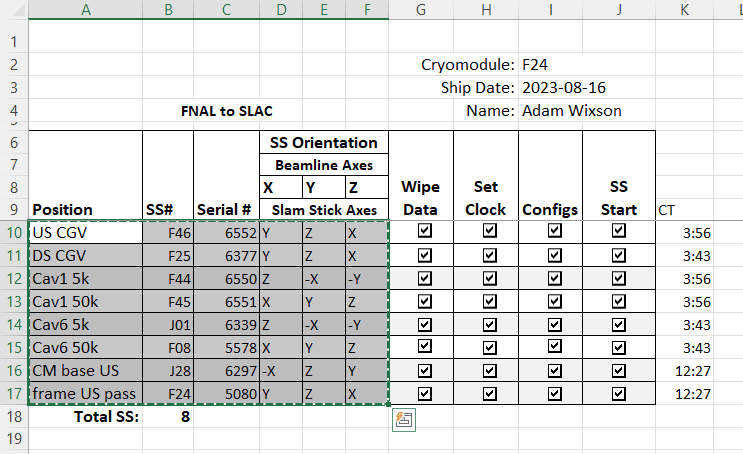

In [3]:
#Ensure pasting is done on the blank lines between the sets of """.  The """ should not have sensor data in that line.

sensor_def="""
US CGV	F46	6552	Y	Z	X
DS CGV	F25	6377	Y	Z	X
Cav1 5k	F44	6550	Z	-X	-Y
Cav1 50k	F45	6551	X	Y	Z
Cav6 5k	J01	6339	Z	-X	-Y
Cav6 50k	F08	5578	X	Y	Z
CM base US	J28	6297	-X	Z	Y
frame US pass	F24	5080	Y	Z	X
"""

#used for testing purposes
sensor_def="""
Inner Frame	F45	5578	Z	X	Y
"""
#Cav6 50k	F08	5578	X	Y	Z

sensors=[line.split('\t') for line in sensor_def.split('\n')]
sensors=sensors[1:len(sensors)-1]  #removes blank first and last entries from the multiline string method
print(sensors)

[['Inner Frame', 'F45', '5578', 'Z', 'X', 'Y']]


In [4]:
#define colors for printing
class colors: 

    reset = '\033[0m'
    bold = '\033[01m'
    disable = '\033[02m'
    underline = '\033[04m'
    reverse = '\033[07m'
    strikethrough = '\033[09m'
    invisible = '\033[08m'

    class fg:
        black = '\033[30m'
        red = '\033[31m'
        green = '\033[32m'
        orange = '\033[33m'
 
    class bg:
        black = '\033[40m'
        red = '\033[41m'
        green = '\033[42m'
        orange = '\033[43m'

In [10]:
def histofull(acc,dirs,desc):
    #used to plot XYZ in correct order

    labels=["X", "Y", "Z"]
    
    plt.figure(figsize=[12,8], dpi=150)
    plt.style.use('seaborn-v0_8-notebook')
    
    for i in range(3):
        bins=np.arange(np.trunc(acc[i+1].min())-1,np.trunc(acc[i+1].max())+1,stepsize)
        plt.hist(acc[i+1]-np.median(acc[i+1]), bins, histtype='step', log=True, lw=2, label=labels[i])
    
    plt.xlabel("Acceleration (g)")
    plt.ylabel("Counts")
    plt.legend()
    plt.grid()
    plt.title(tname + " " + desc +" Combined Histogram")
    plt.savefig(f"{tname} {desc} Combined Histogram.png", bbox_inches="tight", dpi=150)
    plt.show()
    plt.close()

In [11]:
def tseriesfull(acc,dirs,desc):
    #used to plot XYZ in correct order
    
    labels=["X", "Y", "Z"]
    
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1]) 
    plt.figure(figsize=[12,8], dpi=200)
    plt.style.use('seaborn-v0_8-notebook')
    plt.suptitle(f"{tname} {desc} Combined Timeseries")
    
    for idx in range(3):
        ax1=plt.subplot(gs[idx])
        plt.plot(acc[0], acc[idx+1])
        plt.plot(acc[0], acc[idx+4])
        plt.grid()
        plt.ylabel(f"{labels[idx]} Acceleration (g)")

    plt.xlabel("Time since start (hours)")
    plt.savefig(f"{tname} {desc} Combined Timeseries.png", bbox_inches="tight", dpi=150)
    plt.show()
    plt.close()

In [12]:
def find_file(sensor):
    filstart=sensor[1]
    for file in os.listdir("./"):
        if file.startswith(filstart):
            filname=file
    return filname

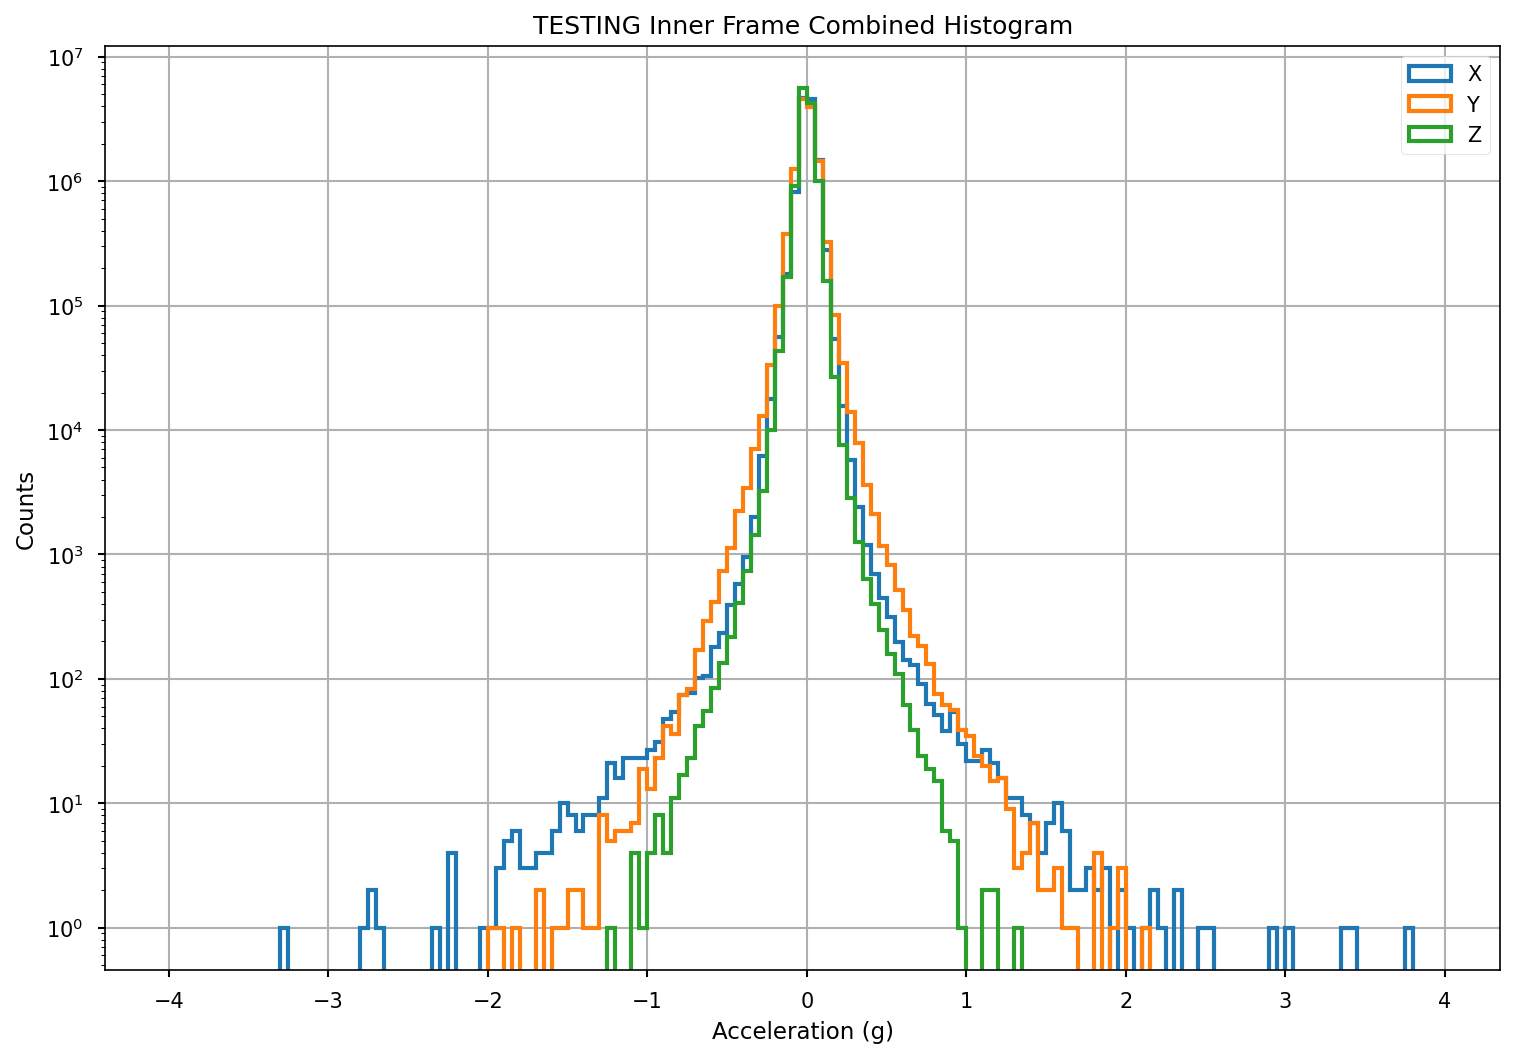

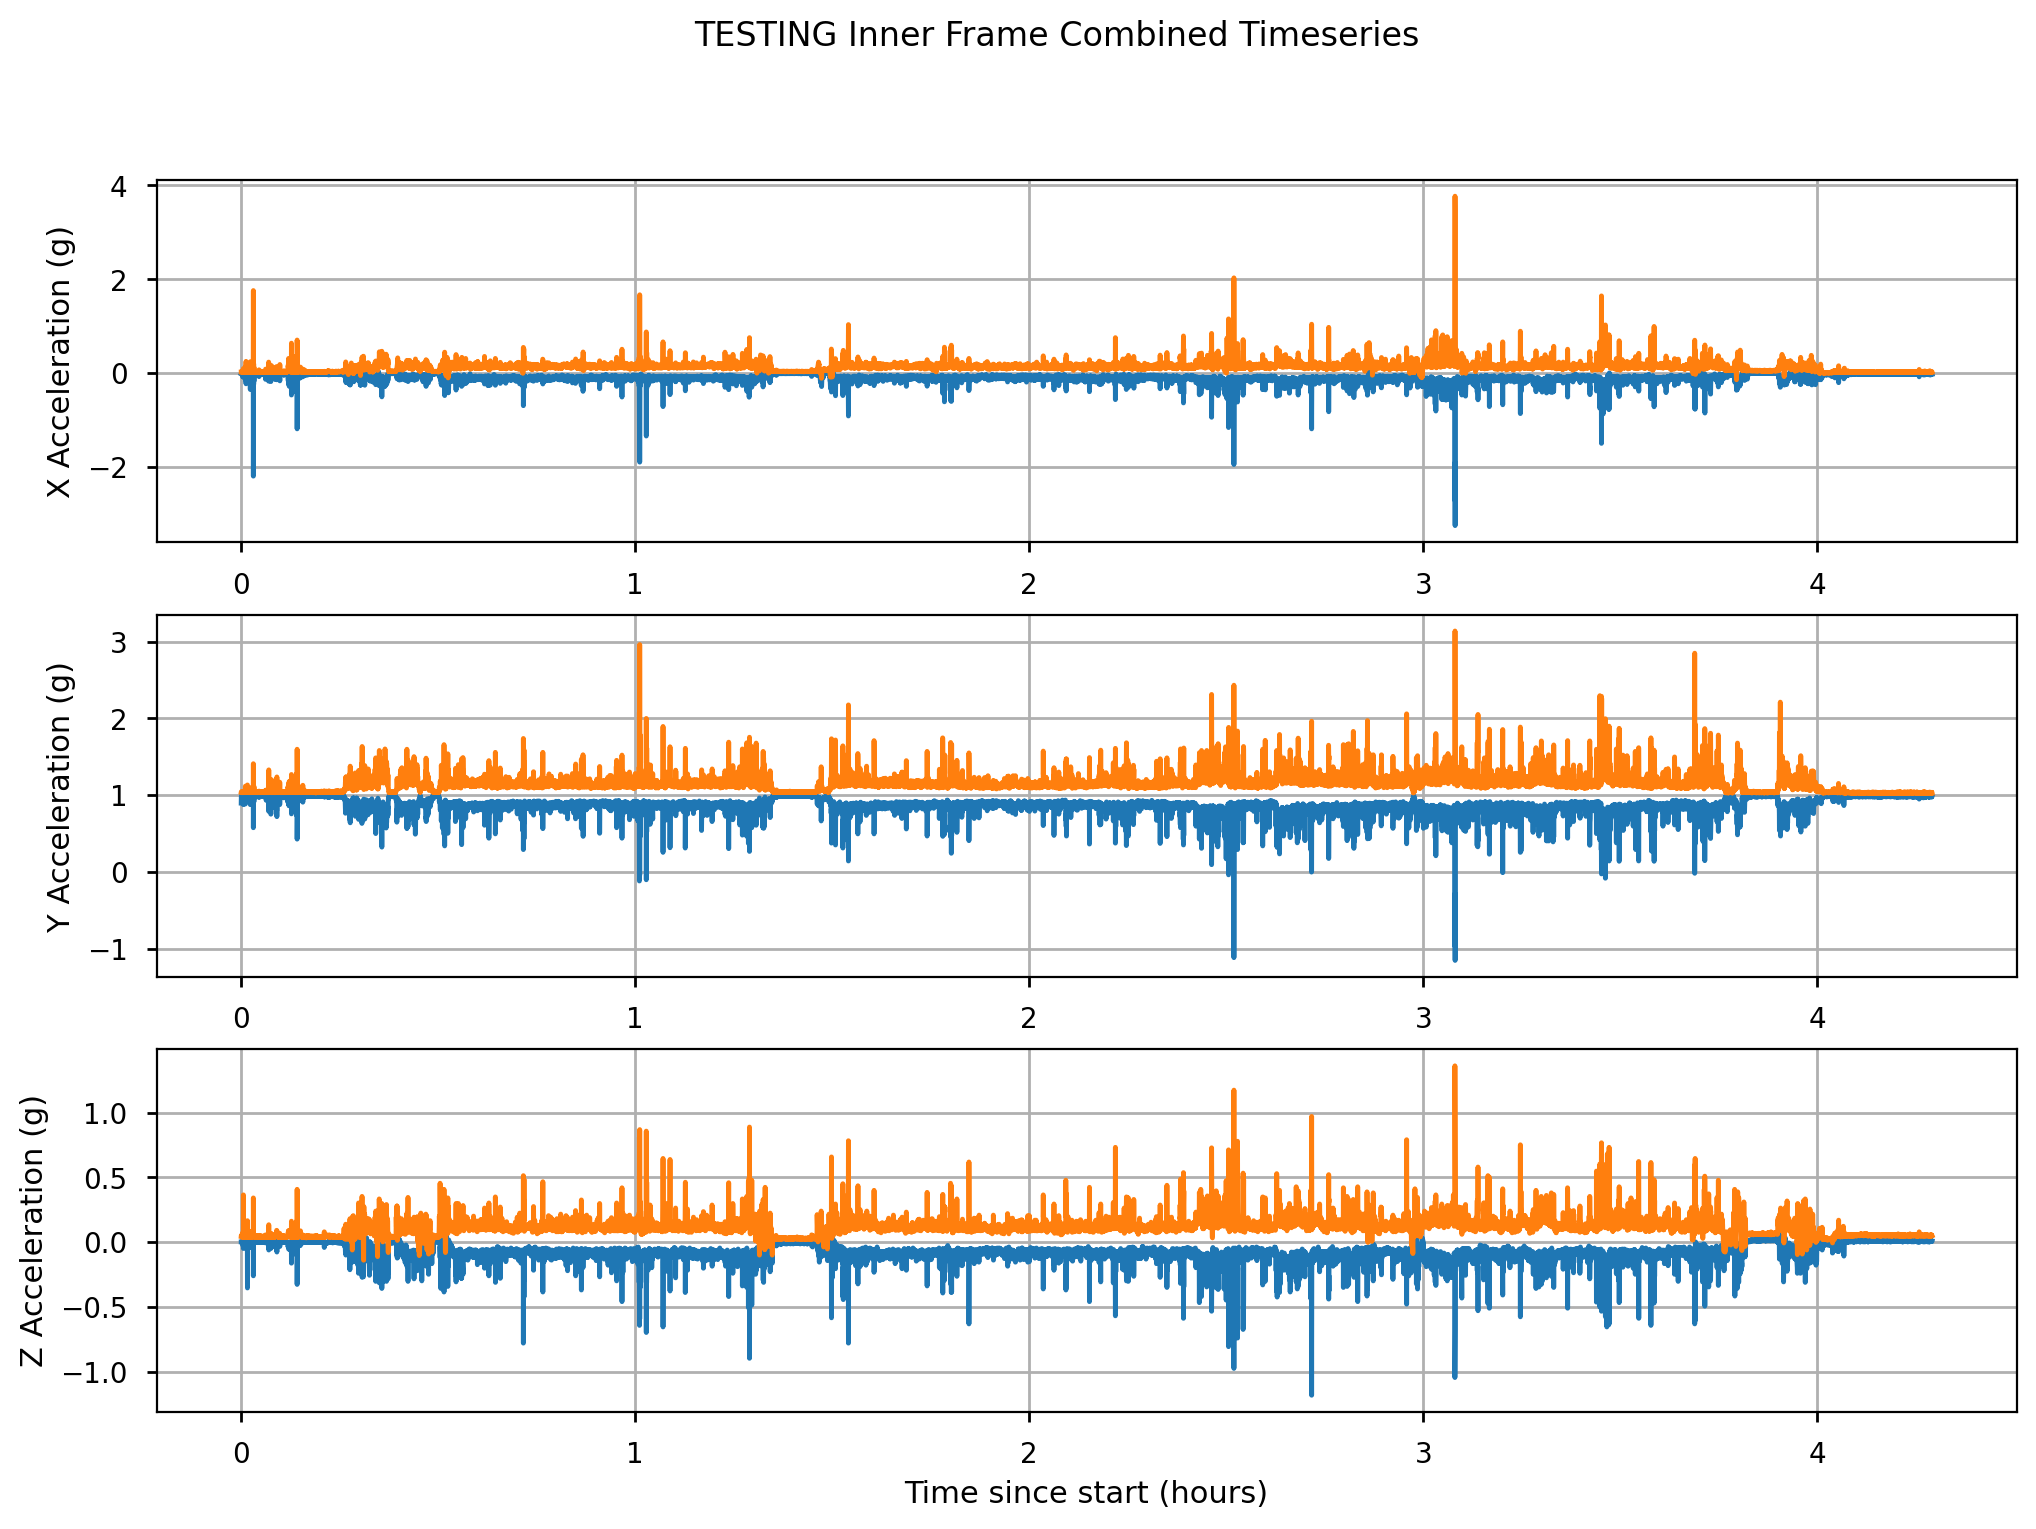

In [13]:
#Main code block

if tstamp: print("Start at ", datetime.now())
for sensor in sensors:
    filname=find_file(sensor)
    dirs=[]
    with ed.get_doc(filname) as rawslam:
        if tstamp: print(f"Opened {filnam} at {datetime.now()}")
        ed.get_channel_table(rawslam).data
        for i in range(3):  #loops over the 3 axes of channels in the data file
            if tstamp: print("Importing data for", sensor[i+3], "tseries at: ", datetime.now())
            accel=ed.to_pandas(ed.get_channels(rawslam, measurement_type="accel", subchannels=True)[i], time_mode='timedelta').astype(np.float32)
            
            if "-" in sensor[i+3]:  #handles inversion if needed and removing negative sign
                print(f"Needed to rotate for {sensor[0]} {sensor[i+3]}")
                accel=accel*-1
                sensor[i+3]=sensor[i+3][-1]
            
            order={'X':0, 'Y':1, 'Z':2}
            
            if tstamp: print("Resampling for", sensor[i+3], "tseries at: ", datetime.now())
            
            #desample to 1Hz for easy plotting and analysis
            dsamplemin=accel.resample('1s').min()
            dsamplemax=accel.resample('1s').max()
            
            #remove DC components
            dcremovemin=dsamplemin-dsamplemin.median()  
            dcremovemax=dsamplemax-dsamplemax.median()
            
            if i==0:
                full=np.zeros((4,len(accel)), dtype=np.float32)
                full[0]=accel.index.to_numpy()
                
                fullds=np.zeros((7,len(dsamplemin)), dtype=np.float32)
                fullds[0]=dsamplemin.index.to_numpy().astype(np.float32)/float(1e9)/3600 #convert to hours
            
            #this logic puts the axis data into the correct column depending on sensor rotation
            # full is [time, x, y, z]
            # fullds is [time, xmin, ymin, zmin, xmax, ymax, zmax]
            
            full[1+order[sensor[i+3]]]=accel.to_numpy().flatten()
            
            fullds[1+order[sensor[i+3]]]=dsamplemin.to_numpy().flatten()
            fullds[4+order[sensor[i+3]]]=dsamplemax.to_numpy().flatten()
            
            del accel  #memory management, this can get big
            
            #Check criteria
            if float(dcremovemin.min()) < -spec or float(dcremovemax.max()) > spec:
                outstr=colors.fg.red + colors.bold + "WARNING! " + colors.reset + sensor[0] + " " + sensor[i+3] + " over " + str(spec) + "g specification"
                out.append(outstr)
            else:
                outstr=colors.fg.green + "OK " + colors.reset + sensor[0] + " " + sensor[i+3] + " GOOD."
                out.append(outstr)
        
        #build combined histogram
        if tstamp: print(f"Plotting histogram for {sensor[i+3]} at: {datetime.now()}.")
        histofull(full, dirs, sensor[0])
        
        #build combined time series plot
        if tstamp: print(f"Plotting full time series for {sensor[i+3]} at {datetime.now()}.")
        tseriesfull(fullds, dirs, sensor[0])

In [9]:
#Print the summary output

for line in out:
    print(line)

OK Inner Frame Z GOOD.
WARNING! Inner Frame X over 1.5g specification
WARNING! Inner Frame Y over 1.5g specification
